In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pydrake.all import Simulator, StartMeshcat, LogVectorOutput, RandomGenerator
import numpy as np
import sponana.sim as sim
from pydrake.all import (
    AddMultibodyPlantSceneGraph,
    Box,
    ConnectPlanarSceneGraphVisualizer,
    DiagramBuilder,
    FixedOffsetFrame,
    JointIndex,
    Parser,
    PlanarJoint,
    RandomGenerator,
    RigidTransform,
    RotationMatrix,
    Simulator,
    StartMeshcat,
    UniformlyRandomRotationMatrix,
)

In [3]:
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7002


In [4]:
# Clean up the Meshcat instance.
meshcat.Delete()
meshcat.DeleteAddedControls()

rng = np.random.default_rng(145)  # this is for python
generator = RandomGenerator(rng.integers(0, 1000))  # this is for c++

add_spot = True
simulation_time = -1  # run indefinitely until ESC is pressed
# simulation_time = 1
table_height = 0.2
debug = True


Logging system info...
Camera pose: RigidTransform(
  R=RotationMatrix([
    [-0.00842685086773652, 0.49998224673093455, -0.8659946542204171],
    [0.9999644934618693, 0.004213425433868259, -0.007297866925362767],
    [0.0, -0.8660254037844387, -0.4999999999999999],
  ]),
  p=[0.5567144699048837, -0.0037356336952010494, 0.495],
)
Table 0 pose: RigidTransform(
  R=RotationMatrix([
    [1.0, 0.0, 0.0],
    [0.0, 1.0, 0.0],
    [0.0, 0.0, 1.0],
  ]),
  p=[0.0, 0.0, 0.19925],
)
Table 1 pose: RigidTransform(
  R=RotationMatrix([
    [1.0, 0.0, 0.0],
    [0.0, 1.0, 0.0],
    [0.0, 0.0, 1.0],
  ]),
  p=[0.0, 2.0, 0.19925],
)
Table 2 pose: RigidTransform(
  R=RotationMatrix([
    [1.0, 0.0, 0.0],
    [0.0, 1.0, 0.0],
    [0.0, 0.0, 1.0],
  ]),
  p=[0.0, -2.0, 0.19925],
)


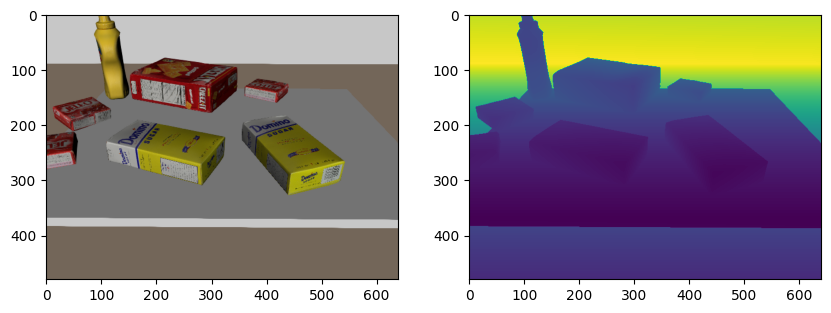

In [18]:
simulator, diagram = sim.clutter_gen(meshcat, rng, table_height=table_height, debug=debug, simulation_time=simulation_time)

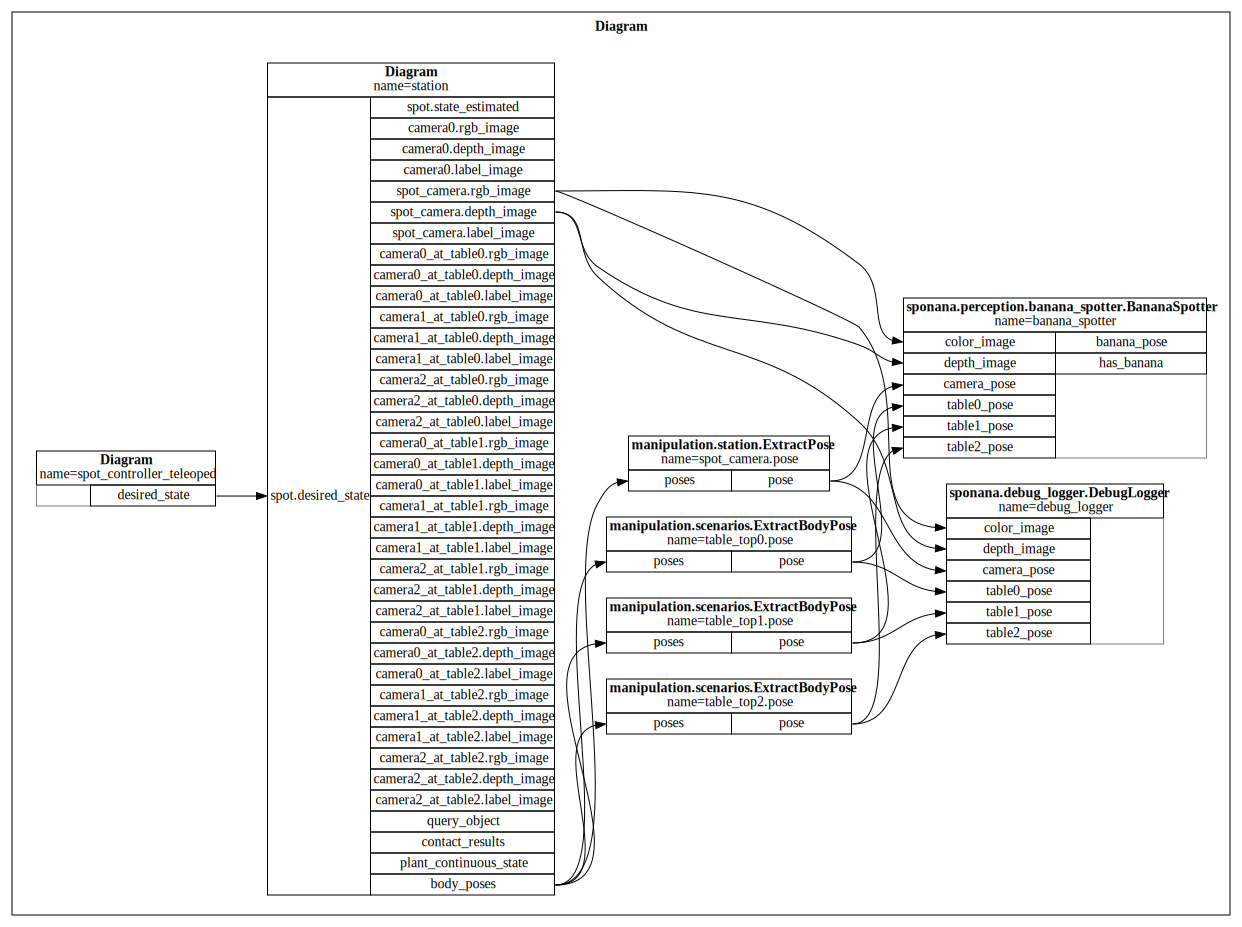

In [20]:
import sponana
sponana.utils.visualize_diagram(diagram, max_depth=1)

In [37]:
from sponana.hardcoded_cameras import get_camera_poses_table_frame

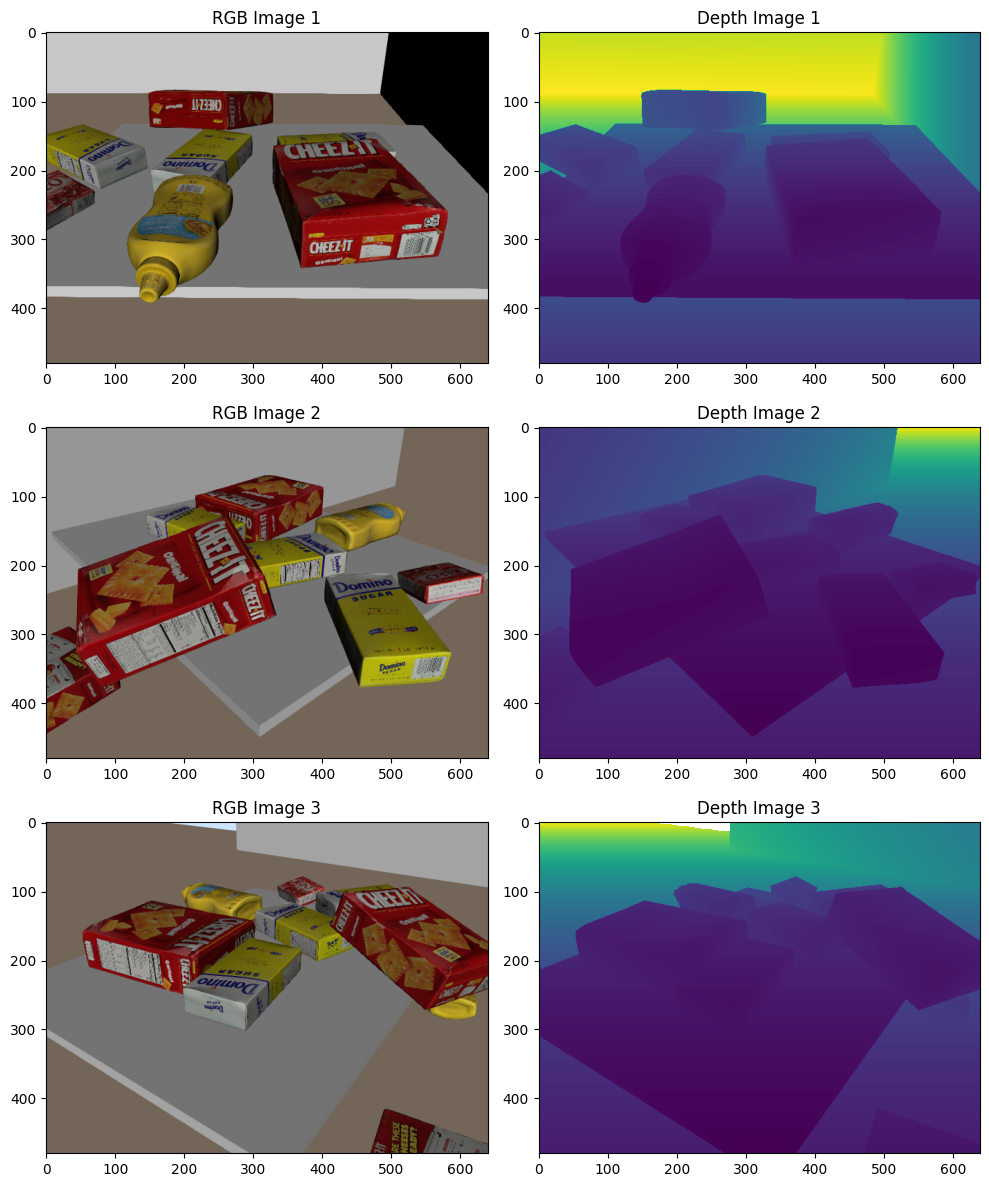

In [47]:
import matplotlib.pyplot as plt

context = simulator.get_mutable_context()
station = diagram.GetSubsystemByName("station")
scontext = station.GetMyContextFromRoot(context)

fig, axs = plt.subplots(3, 2, figsize=(10, 12))

table_idx = 0
camera_poses = get_camera_poses_table_frame()
rgb_imgs = []
depth_imgs = []
for camera_idx in range(3):
    color_image = station.GetOutputPort(f"camera{camera_idx}_at_table{table_idx}.rgb_image").Eval(scontext)
    depth_image = station.GetOutputPort(f"camera{camera_idx}_at_table{table_idx}.depth_image").Eval(scontext)
    rgb_imgs.append(color_image.data)
    depth_imgs.append(depth_image.data)

    axs[camera_idx, 0].imshow(color_image.data)
    axs[camera_idx, 0].set_title(f"RGB Image {camera_idx+1}")
    axs[camera_idx, 1].imshow(depth_image.data)
    axs[camera_idx, 1].set_title(f"Depth Image {camera_idx+1}")

# Serialize the images and camera poses
import pickle
with open("images.pkl", "wb") as f:
    pickle.dump(rgb_imgs, f)
    pickle.dump(depth_imgs, f)
    pickle.dump(camera_poses, f)

plt.tight_layout()
plt.show()

[RigidTransform(
  R=RotationMatrix([
    [-0.008426572055398018, 0.49998224790571183, -0.865994656255191],
    [0.9999644958114239, 0.004213286027699008, -0.007297625466794737],
    [0.0, -0.8660254037844386, -0.49999999999999983],
  ]),
  p=[0.5567144688632728, -2.003735510093671, 0.29574999999999996],
), RigidTransform(
  R=RotationMatrix([
    [0.7564493864543211, -0.32702611735642795, 0.5664258506633156],
    [-0.6540522347128561, -0.3782246932271605, 0.6551043853465944],
    [0.0, -0.8660254037844387, -0.4999999999999999],
  ]),
  p=[-0.4067672805262673, -2.5122634135249005, 0.29574999999999996],
), RigidTransform(
  R=RotationMatrix([
    [-0.8214529060279898, -0.28513817842327355, 0.49387381220674975],
    [-0.5702763568465472, 0.4107264530139948, -0.7113990846327904],
    [0.0, -0.8660254037844387, -0.4999999999999999],
  ]),
  p=[-0.35091572089593653, -1.5118080969070375, 0.29574999999999996],
)]


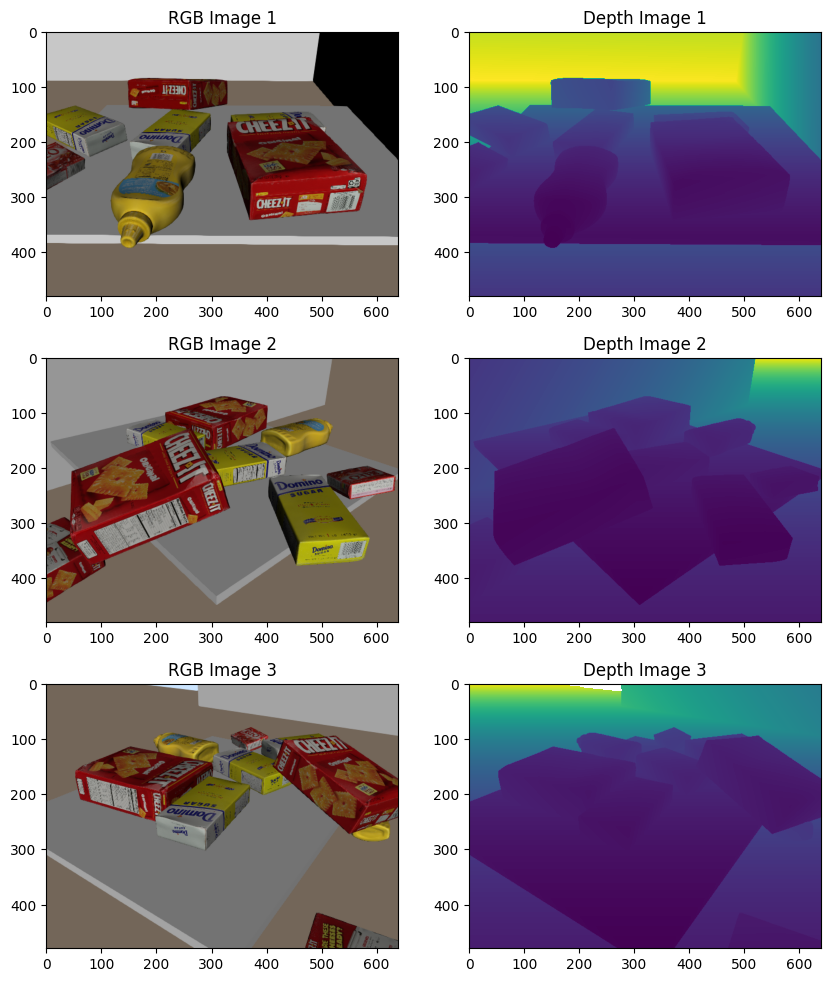

In [48]:
# Test loading in camera poses and images:
with open("images.pkl", "rb") as f:
    rgb_imgs = pickle.load(f)
    depth_imgs = pickle.load(f)
    camera_poses = pickle.load(f)

# Print poses and visualize images in same grid as above:
print(camera_poses)
fig, axs = plt.subplots(3, 2, figsize=(10, 12))
for camera_idx in range(3):
    axs[camera_idx, 0].imshow(rgb_imgs[camera_idx])
    axs[camera_idx, 0].set_title(f"RGB Image {camera_idx+1}")
    axs[camera_idx, 1].imshow(depth_imgs[camera_idx])
    axs[camera_idx, 1].set_title(f"Depth Image {camera_idx+1}")

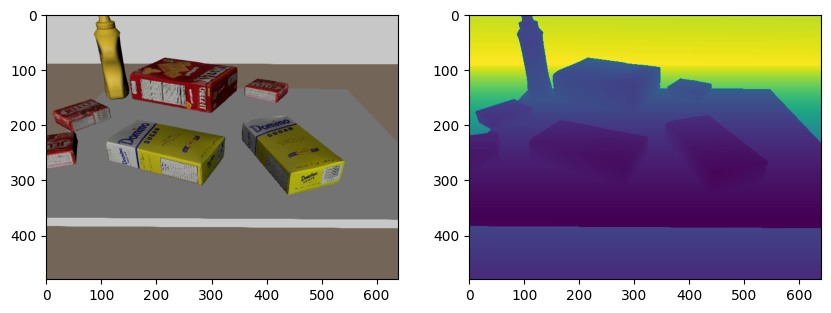

In [43]:
# Check cameras
import matplotlib.pyplot as plt
context = simulator.get_mutable_context()
station = diagram.GetSubsystemByName("station")
context = station.GetMyContextFromRoot(context)
table_idx = 1
camera_idx = 0
color_image = station.GetOutputPort(f"camera{camera_idx}_at_table{table_idx}.rgb_image").Eval(context)
depth_image = station.GetOutputPort(f"camera{camera_idx}_at_table{table_idx}.depth_image").Eval(context)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(color_image.data)
plt.subplot(1, 2, 2)
plt.imshow(depth_image.data)

array([[[1.6852987 ],
        [1.6852757 ],
        [1.685253  ],
        ...,
        [1.670806  ],
        [1.6707838 ],
        [1.6707612 ]],

       [[1.686662  ],
        [1.6866393 ],
        [1.6866161 ],
        ...,
        [1.6721461 ],
        [1.6721236 ],
        [1.6721011 ]],

       [[1.6880277 ],
        [1.6880044 ],
        [1.6879817 ],
        ...,
        [1.6734883 ],
        [1.6734655 ],
        [1.6734432 ]],

       ...,

       [[0.58546495],
        [0.58546495],
        [0.58546495],
        ...,
        [0.58546495],
        [0.58546495],
        [0.58546495]],

       [[0.5844439 ],
        [0.5844439 ],
        [0.5844439 ],
        ...,
        [0.5844439 ],
        [0.5844439 ],
        [0.5844439 ]],

       [[0.5834268 ],
        [0.5834268 ],
        [0.5834268 ],
        ...,
        [0.5834268 ],
        [0.5834268 ],
        [0.5834268 ]]], dtype=float32)